# Grasp-and-Lift(GAL) EEG Detection
## Hand movements の分類
- 被験者数: **12**
- 各被験者ごとの試行のデータ系列数: **10**
- 各被験者の試行回数: **約30**(試行回数は各系列データごとに異なる) 

training set: 各被験者の最初の8つの試行のデータ系列<br/>
test set: 第9,10番目の試行のデータ系列<br/>

### ラベル
各GALには、6つのイベントを検出するタスク 
(それぞれのイベントにおいて2値分類(ラベル0,1))
　
1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

これらのイベントは常に同じ順序で発生する<br/>
training setには、各件名+シリーズの組み合わせごとに2つのファイル<br/>

### データ
* *_data.csvファイルには、生の32チャンネルEEG(Electroencephalography, 脳波)データ（サンプリングレート500Hz）
* *_events.csvファイルには、すべてのイベントのフレーム・ワイズ・ラベル(1の連続)が含まれる
 * 6つのラベル列は、対応するイベントが±150ms（±75フレーム）以内に発生したかどうかに応じて、ゼロまたは1のいずれか

## 目標
#### 理想: このイベントの窓全体を完璧に予測

# パッケージの準備

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

# 関数の準備

In [18]:
### データの読み込み ###

def prepare_data_train(fname):
    """ 訓練データの読み込み """
    # EEGデータ読み込み
    data = pd.read_csv(fname)
    # fnameイベントファイルの名前に変換
    events_fname = fname.replace('_data','_events')
    # イベントデータの読み込み
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#id列を削除
    labels=labels.drop(['id' ], axis=1)#id列を削除
    return  clean,labels

def prepare_data_test(fname):
    """ テストデータの読み込み """
    # EEGデータの読み込み
    data = pd.read_csv(fname)
    return data

In [10]:
### 特徴ベクトルの標準化 ###

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #ここで他のpreprocessingを追加
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #ここで他のpreprocessingを追加
    return X_prep

In [30]:
# ダウンサンプリングてきななにか
subsample=100

## 各GALごとに, 6 イベント(ラベル):

1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

In [20]:
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

## 12 の被験者

In [32]:
#被験者数
subjects = range(1,13)
ids_tot = []
pred_tot = []

# 訓練過程

In [33]:
""" 
各被験者: 訓練->テストデータを予測
8個のtrain系列データと2個のtest系列データ 
"""
for subject in subjects:
    y_raw = []
    raw = []
    ### 訓練データの読み込み #################################
    fnames = glob('input/train/subj%d_series*_data.csv' % (subject))
    for fname in fnames:
        # 訓練データの読み込み
        data,labels = prepare_data_train(fname)
        # すべての系列データ(1-8)
        raw.append(data)
        y_raw.append(labels)

    # 1次元のlistにする
    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #numpy arrayにする
    X_train =np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    
    
    ### テストデータの読み込み ###############################
    
    fnames = glob('input/test/subj%d_series*_data.csv' % (subject))
    test = []
    idx = []
    for fname in fnames:
        data = prepare_data_test(fname)
        test.append(data)
        idx.append(np.array(data['id']))
    X_test = pd.concat(test)
    ids = np.concatenate(idx)
    ids_tot.append(ids)
    X_test = X_test.drop(['id' ], axis=1)#remove id
    #transform test data in numpy array
    X_test = np.asarray(X_test.astype(float))

    
    ### 学習器 ############################################
    ''' ロジスティック回帰 '''
    lr = LogisticRegression()
    pred = np.empty((X_test.shape[0],6))
    
    ### 前処理 ############################################
    X_train = data_preprocess_train(X_train)
    X_test = data_preprocess_test(X_test)
    
    ### 各イベントごとに学習 ################################
    for i in range(6):
        y_train= y[:,i]
        print('Train subject %d, class %s' % (subject, cols[i]))
        lr.fit(X_train[::subsample,:],y_train[::subsample])
        pred[:,i] = lr.predict_proba(X_test)[:,1]

    pred_tot.append(pred)

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

# テストデータの予測をKaggleのSubmissionの指定形式でファイルに出力

In [34]:
### submissionファイル名
submission_file = 'grasp-sub-simple.csv'

# create pandas object for sbmission
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))

# write file
submission.to_csv(submission_file,index_label='id',float_format='%.3f')

# 交差検証法を用いたAUC(Area Under the Curve)による予測能の比較
- AUC: ROC曲線(Receiver Operatorating Characteristic curve、受信者動作特性曲線)の面積
- 混合行列を定量的に比較し，予測能を判断するもの

[0.7469592743845781, 0.76374334308707814, 0.74484090200460518, 0.75370565338388296, 0.854273812760588, 0.7991054116356181]
[0.68682644300259277, 0.67413345308830552, 0.54789517976692104, 0.64812241169315843, 0.75375391623161281, 0.7472495308946745]
[0.72291788702606752, 0.71801807291811515, 0.72033897308960215, 0.70554150707062713, 0.64307553524417005, 0.65927863079000382]
[0.725563597077719, 0.76386438576204196, 0.75625091453651461, 0.72327819660503057, 0.70415836094886308, 0.67207823591389249]
[0.6079616547397545, 0.68333031171500369, 0.6931500618298424, 0.70907075676192766, 0.66002234542889437, 0.6881960784136073]
[0.68570192112661732, 0.68854131002763985, 0.71822146222106376, 0.73001750504269158, 0.81521559264085108, 0.78394593018218195]
[0.78678924938592876, 0.78138862438451162, 0.77225465143802685, 0.75238155424706532, 0.78798830504209449, 0.77557925585855947]
[0.64262538801414726, 0.69711385907918777, 0.7233446365892694, 0.71428458414823692, 0.73376103931769299, 0.72093047329469

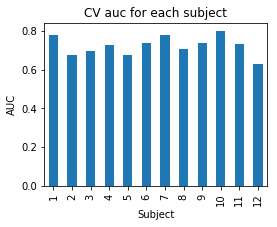

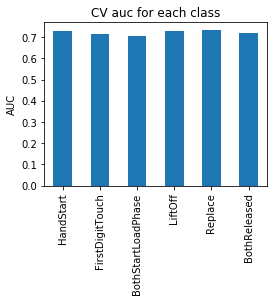

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score

from joblib import Parallel, delayed


def fit(X,y):
    # Do here you training
    clf = LogisticRegression()
    clf.fit(X,y)
    return clf

def predict(clf,X):
    # do here your prediction
    preds = clf.predict_proba(X)
    return np.atleast_2d(preds[:,clf.classes_==1])
    
#series used for CV
series = range(2,9)

In [ ]:
#######number of subjects###############
subjects = range(1,13)
auc_tot = []
pred_tot = []
y_tot = []

In [ ]:
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw= []
    raw = []
    sequence = []
    ################ READ DATA ################################################
    
    for ser in series:
        fname =  'input/train/subj%d_series%d_data.csv' % (subject,ser)
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
        sequence.extend([ser]*len(data))

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    sequence = np.asarray(sequence)
#     print(sequence.shape, y.shape, X.shape)


    ################ Train classifiers ########################################
    cv = LeaveOneGroupOut()
    cv.get_n_splits(groups=sequence)
    pred = np.empty((X.shape[0],6))

    for train, test in cv.split(X, y, sequence):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        #apply preprocessing
        X_train=data_preprocess_train(X_train)
        X_test=data_preprocess_test(X_test)
        clfs = Parallel(n_jobs=6)(delayed(fit)(X_train[::subsample,:],y_train[::subsample,i]) for i in range(6))
        preds = Parallel(n_jobs=6)(delayed(predict)(clfs[i],X_test) for i in range(6))
        pred[test,:] = np.concatenate(preds,axis=1)
    pred_tot.append(pred)
    y_tot.append(y)
    # get AUC
    auc = [roc_auc_score(y[:,i],pred[:,i]) for i in range(6)]     
    auc_tot.append(auc)
    print(auc)

pred_tot = np.concatenate(pred_tot)
y_tot = np.concatenate(y_tot)
global_auc = [roc_auc_score(y_tot[:,i],pred_tot[:,i]) for i in range(6)]

print('Global AUC : %.4f' % np.mean(global_auc))

auc_tot = np.asarray(auc_tot)
results = pd.DataFrame(data=auc_tot, columns=cols, index=subjects)
results.to_csv('results_cv_auc.csv')

plt.figure(figsize=(4,3))
results.mean(axis=1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('CV auc for each subject')
plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')

plt.figure(figsize=(4,3))
results.mean(axis=0).plot(kind='bar')
plt.ylabel('AUC')
plt.title('CV auc for each class')
plt.savefig('cross_val_auc_class.png' ,bbox_inches='tight')

# やること
## 前処理
- ローバスフィルタ，メディアンフィルタとか
- ダウンサンプリングとか
- ブリンクを取って，加算平均とか

## 学習
- 学習器の比較
 - kernel SVM
 - EXBoost
 - DNN

## 可視化
- データ可視化
- 結果可視化